In [1]:
# =========================================
# 0) Warning Management (UYARI TEMİZLEME)
# =========================================
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =========================================
# 1) Kütüphaneler
# =========================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
from sklearn.decomposition import TruncatedSVD

# =========================================
# 2) Veri Yükleme
# =========================================
file_path = "/Users/revahauctepe/Desktop/SonHali_Kategorili_Liste.xlsx"
df = pd.read_excel(file_path)

print("Data shape:", df.shape)
display(df.head())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDuplicated rows:", df.duplicated().sum())

print("\nTarget distribution (LC_Kategori):")
print(df["LC_Kategori"].value_counts())

# =========================================
# 3) Features ve Target
# =========================================
target_col = "LC_Kategori"

if "ÖğrenciKimlik-no" in df.columns:
    df_model = df.drop(columns=["ÖğrenciKimlik-no"])
else:
    df_model = df.copy()

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# =========================================
# 4) Train / Test Split
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================================
# 5) Preprocessing (OneHot + Scaling)
# =========================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(with_mean=False), numeric_features),
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

print("\nEncoded X_train shape:", X_train_enc.shape)

# =========================================
# 6) Model Değerlendirme Fonksiyonu
# =========================================
def eval_model(stage, name, model, X_tr, y_tr, X_te, y_te, results_list):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)

    print(f"\n=== {stage} | {name} ===")
    print("Accuracy:", acc)
    print("F1 macro:", f1)
    print("\nClassification Report:\n")
    print(classification_report(y_te, y_pred, zero_division=0))

    results_list.append({
        "Stage": stage,
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1
    })

# =========================================
# 7) Modeller (REVİZE)
# =========================================
logreg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

knn = KNeighborsClassifier(n_neighbors=7)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

results = []

# =========================================
# 8) Stage 1: Original Features
# (KNN çıkarıldı – yüksek boyut sebebiyle)
# =========================================
stage1 = "Original Features"

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage1, model_name, model,
        X_train_enc, y_train,
        X_test_enc, y_test,
        results
    )

# =========================================
# 9) Stage 2: Feature Selection (RFE)
# =========================================
stage2 = "After Feature Selection (RFE, 40 features)"

rfe_selector = RFE(
    estimator=LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        multi_class="multinomial"
    ),
    n_features_to_select=40,
    step=0.1
)

X_train_fs = rfe_selector.fit_transform(X_train_enc, y_train)
X_test_fs = rfe_selector.transform(X_test_enc)

print("\nAfter RFE shapes:", X_train_fs.shape, X_test_fs.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage2, model_name, model,
        X_train_fs, y_train,
        X_test_fs, y_test,
        results
    )

# =========================================
# 10) Stage 3: Dimension Reduction (TruncatedSVD)
# =========================================
stage3 = "After Dimension Reduction (TruncatedSVD, n=20)"

svd = TruncatedSVD(n_components=20, random_state=42)

X_train_dr = svd.fit_transform(X_train_enc)
X_test_dr = svd.transform(X_test_enc)

print("\nAfter DR shapes:", X_train_dr.shape, X_test_dr.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("KNN (k=7)", knn),
    ("RandomForest", rf)
]:
    eval_model(
        stage3, model_name, model,
        X_train_dr, y_train,
        X_test_dr, y_test,
        results
    )

# =========================================
# 11) Summary Table (AKADEMİK)
# =========================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=["F1_macro", "Accuracy"],
    ascending=False
).reset_index(drop=True)

print("\n===== Summary Table (Accuracy & F1) =====")
display(results_df)


Data shape: (13436, 6)


,ÖğrenciKimlik-no,Cinsiyet,Fakülte,Bölüm,Kitap-ID,LC_Kategori
0,509005326,Kadın,Turizm Fakültesi,Gastronomi ve Mutfak Sanatları,GY151,Diğerleri
1,421475486,Kadın,Mühendislik ve Doğa Bilimleri Fakültesi,Biyomühendislik,B3004,Bilim
2,660301107,Erkek,Sağlık Bilimleri Fakültesi,Odyoloji,Tip4081,Tıp
3,534575034,Kadın,Edebiyat Fakültesi,Sosyoloji Bölümü,DE2527,Dil ve Edebiyat
4,331718324,Kadın,Hukuk Fakültesi,Hukuk Bölümü,H9821,Hukuk



Missing values per column:
ÖğrenciKimlik-no    0
Cinsiyet            0
Fakülte             0
Bölüm               0
Kitap-ID            0
LC_Kategori         0
dtype: int64

Duplicated rows: 0

Target distribution (LC_Kategori):
LC_Kategori
Dil ve Edebiyat            3274
Tıp                        2703
Hukuk                      1016
Siyaset Bilimi             1001
Felsefe, Psikoloji, Din     965
Bilim                       957
Güzel Sanatlar              952
Eğitim                      913
Sosyal Bilimler             904
Diğerleri                   751
Name: count, dtype: int64

Numeric features: []
Categorical features: ['Cinsiyet', 'Fakülte', 'Bölüm', 'Kitap-ID']

Encoded X_train shape: (10748, 9797)

=== Original Features | LogisticRegression ===
Accuracy: 0.7347470238095238
F1 macro: 0.6937609550966336

Classification Report:

                         precision    recall  f1-score   support

                  Bilim       0.70      0.92      0.80       192
        Dil ve Edebiyat 

,Stage,Model,Accuracy,F1_macro
0,Original Features,RandomForest,0.735491,0.695510
1,Original Features,LogisticRegression,0.734747,0.693761
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.693761
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.693761
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.693761
5,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.658588
6,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.652530,0.643206


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)


In [3]:
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader

# ================================
# Label Encoding (PyTorch için)
# ================================
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

# ================================
# Torch tensor formatına çevir
# ================================
X_train_torch = torch.tensor(X_train_enc.toarray(), dtype=torch.float32)
X_test_torch  = torch.tensor(X_test_enc.toarray(), dtype=torch.float32)

y_train_torch = torch.tensor(y_train_enc, dtype=torch.long)
y_test_torch  = torch.tensor(y_test_enc, dtype=torch.long)

# ================================
# Dataset & DataLoader
# ================================
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ================================
# Model parametreleri
# ================================
input_dim = X_train_torch.shape[1]
num_classes = len(label_encoder.classes_)

print("Input dim:", input_dim)
print("Num classes:", num_classes)


Input dim: 9797
Num classes: 10


In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).numpy())
            y_prob.extend(probs.numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr")

    return acc, prec, rec, f1, auc


In [8]:
mlp_model = MLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

train_model(mlp_model, train_loader, criterion, optimizer, epochs=20)

mlp_results = evaluate_model(mlp_model, test_loader)
print("MLP Results (Acc, Prec, Recall, F1, AUC):", mlp_results)


Epoch 1/20 - Loss: 216.3828
Epoch 2/20 - Loss: 133.2090
Epoch 3/20 - Loss: 113.1507
Epoch 4/20 - Loss: 88.5413
Epoch 5/20 - Loss: 63.3059
Epoch 6/20 - Loss: 41.0474
Epoch 7/20 - Loss: 24.1963
Epoch 8/20 - Loss: 13.7536
Epoch 9/20 - Loss: 7.9433
Epoch 10/20 - Loss: 4.9614
Epoch 11/20 - Loss: 3.4064
Epoch 12/20 - Loss: 2.4311
Epoch 13/20 - Loss: 1.8344
Epoch 14/20 - Loss: 1.4166
Epoch 15/20 - Loss: 1.1341
Epoch 16/20 - Loss: 0.9055
Epoch 17/20 - Loss: 0.7617
Epoch 18/20 - Loss: 0.6401
Epoch 19/20 - Loss: 0.5425
Epoch 20/20 - Loss: 0.4592
MLP Results (Acc, Prec, Recall, F1, AUC): (0.7589285714285714, 0.7818886595945911, 0.8001184032498945, 0.7379878123967547, 0.9125875747942352)


In [9]:
deep_mlp_model = DeepMLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp_model.parameters(), lr=0.001)

train_model(deep_mlp_model, train_loader, criterion, optimizer, epochs=25)

deep_mlp_results = evaluate_model(deep_mlp_model, test_loader)
print("Deep MLP Results (Acc, Prec, Recall, F1, AUC):", deep_mlp_results)


Epoch 1/25 - Loss: 162.4351
Epoch 2/25 - Loss: 102.8968
Epoch 3/25 - Loss: 33.6512
Epoch 4/25 - Loss: 9.9268
Epoch 5/25 - Loss: 4.6852
Epoch 6/25 - Loss: 2.8243
Epoch 7/25 - Loss: 2.1531
Epoch 8/25 - Loss: 1.5337
Epoch 9/25 - Loss: 1.4622
Epoch 10/25 - Loss: 1.4994
Epoch 11/25 - Loss: 2.5472
Epoch 12/25 - Loss: 3.5125
Epoch 13/25 - Loss: 4.9377
Epoch 14/25 - Loss: 6.6888
Epoch 15/25 - Loss: 5.2662
Epoch 16/25 - Loss: 4.4475
Epoch 17/25 - Loss: 3.4198
Epoch 18/25 - Loss: 2.8773
Epoch 19/25 - Loss: 2.7894
Epoch 20/25 - Loss: 1.8805
Epoch 21/25 - Loss: 1.9481
Epoch 22/25 - Loss: 1.8287
Epoch 23/25 - Loss: 1.1150
Epoch 24/25 - Loss: 1.1793
Epoch 25/25 - Loss: 1.6961
Deep MLP Results (Acc, Prec, Recall, F1, AUC): (0.7470238095238095, 0.7725181683275931, 0.7903121427957013, 0.7222678915052642, 0.9032358564458853)


In [10]:
results.append({
    "Stage": "Final - PyTorch",
    "Model": "MLP",
    "Accuracy": mlp_results[0],
    "F1_macro": mlp_results[3]
})

results.append({
    "Stage": "Final - PyTorch",
    "Model": "Deep MLP",
    "Accuracy": deep_mlp_results[0],
    "F1_macro": deep_mlp_results[3]
})

results_df = pd.DataFrame(results)
display(results_df)


,Stage,Model,Accuracy,F1_macro
0,Original Features,LogisticRegression,0.734747,0.693761
1,Original Features,RandomForest,0.735491,0.695510
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.693761
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.693761
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.693761
5,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.652530,0.643206
6,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.658588
7,Final - PyTorch,MLP,0.758929,0.737988
8,Final - PyTorch,Deep MLP,0.747024,0.722268


In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [12]:
def plot_multiclass_roc(model, test_loader, n_classes, title):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_score.extend(probs.numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-vs-Rest için binarize
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


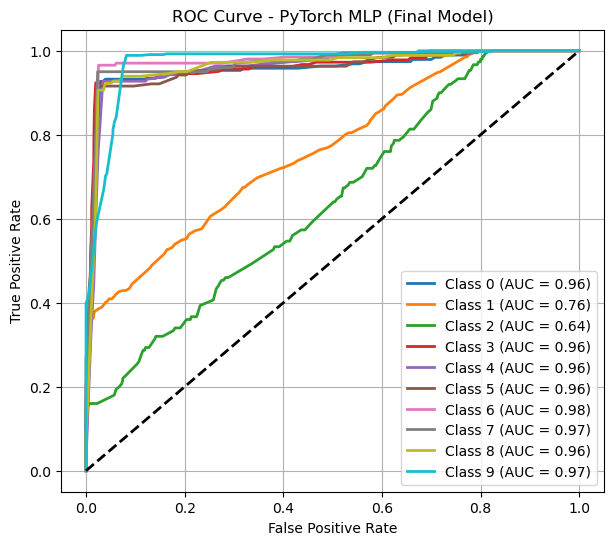

In [13]:
plot_multiclass_roc(
    model=mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch MLP (Final Model)"
)


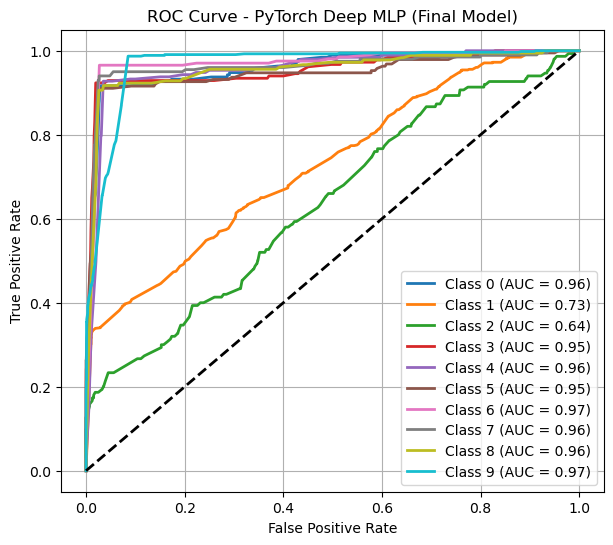

In [14]:
plot_multiclass_roc(
    model=deep_mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch Deep MLP (Final Model)"
)


In [15]:
tuning_results = []

learning_rates = [0.01, 0.001]
epochs_list = [15, 25]

for lr in learning_rates:
    for ep in epochs_list:
        model = MLP(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_model(model, train_loader, criterion, optimizer, epochs=ep)
        acc, prec, rec, f1, auc_score = evaluate_model(model, test_loader)

        tuning_results.append({
            "Model": "MLP",
            "LearningRate": lr,
            "Epochs": ep,
            "Accuracy": acc,
            "F1": f1,
            "AUC": auc_score
        })


Epoch 1/15 - Loss: 160.7302
Epoch 2/15 - Loss: 91.8422
Epoch 3/15 - Loss: 20.2488
Epoch 4/15 - Loss: 2.1124
Epoch 5/15 - Loss: 0.4303
Epoch 6/15 - Loss: 0.1853
Epoch 7/15 - Loss: 0.1069
Epoch 8/15 - Loss: 0.0648
Epoch 9/15 - Loss: 0.0516
Epoch 10/15 - Loss: 0.0418
Epoch 11/15 - Loss: 0.0289
Epoch 12/15 - Loss: 0.0225
Epoch 13/15 - Loss: 0.0194
Epoch 14/15 - Loss: 0.0166
Epoch 15/15 - Loss: 0.0146
Epoch 1/25 - Loss: 160.8347
Epoch 2/25 - Loss: 86.6960
Epoch 3/25 - Loss: 17.4701
Epoch 4/25 - Loss: 2.0132
Epoch 5/25 - Loss: 0.4265
Epoch 6/25 - Loss: 0.1848
Epoch 7/25 - Loss: 0.1015
Epoch 8/25 - Loss: 0.0715
Epoch 9/25 - Loss: 0.0507
Epoch 10/25 - Loss: 0.0441
Epoch 11/25 - Loss: 0.0372
Epoch 12/25 - Loss: 0.0240
Epoch 13/25 - Loss: 0.0217
Epoch 14/25 - Loss: 0.0189
Epoch 15/25 - Loss: 0.0145
Epoch 16/25 - Loss: 0.0124
Epoch 17/25 - Loss: 0.0101
Epoch 18/25 - Loss: 0.0093
Epoch 19/25 - Loss: 0.0082
Epoch 20/25 - Loss: 0.0060
Epoch 21/25 - Loss: 0.0054
Epoch 22/25 - Loss: 0.0052
Epoch 23/25

In [16]:
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)

,Model,LearningRate,Epochs,Accuracy,F1,AUC
0,MLP,0.010,15,0.723214,0.718548,0.910489
1,MLP,0.010,25,0.749628,0.729573,0.912260
2,MLP,0.001,15,0.758929,0.737988,0.911080
3,MLP,0.001,25,0.760045,0.739193,0.913423


In [17]:
final_results = results_df.copy()

final_results.loc[len(final_results)] = [
    "Final - PyTorch", "MLP (Best Tuned)",
    mlp_results[0], mlp_results[3]
]

final_results.loc[len(final_results)] = [
    "Final - PyTorch", "Deep MLP",
    deep_mlp_results[0], deep_mlp_results[3]
]

display(final_results)


,Stage,Model,Accuracy,F1_macro
0,Original Features,LogisticRegression,0.734747,0.693761
1,Original Features,RandomForest,0.735491,0.695510
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.693761
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.693761
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.693761
5,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.652530,0.643206
6,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.658588
7,Final - PyTorch,MLP,0.758929,0.737988
8,Final - PyTorch,Deep MLP,0.747024,0.722268
9,Final - PyTorch,MLP (Best Tuned),0.758929,0.737988


In [18]:
best_model = final_results.sort_values("F1_macro", ascending=False).iloc[0]

print("Best Model Based on F1-score:")
print(best_model)


Best Model Based on F1-score:
Stage       Final - PyTorch
Model                   MLP
Accuracy           0.758929
F1_macro           0.737988
Name: 7, dtype: object
